# Improvement Notebook Objective: Code Cleanup and Library Update for FCPO

In this notebook, we have extracted the working code from the original paper's GitHub repository: [FCPO GitHub Repository](https://github.com/TobyGE/FCPO).

## Goals:
1. **Code Simplification**:  
   - Remove redundant versions of classes, functions, and unnecessary code present in the original repository.  
   - Streamline the codebase to improve readability and maintainability.  

2. **Library Updates**:  
   - Update outdated libraries to their newer versions.  
   - Modify the code as necessary to ensure compatibility with the updated library versionnotebook
This project focuses on enhancing the functionality and usability of the code while maintaining its origi
## Kaggle specific issues:
Python and library versions in Kaggle's environment are managed and periodically upgraded by the Kaggle team. As a result, the imported versions may not always be the latest but are newer than those used in the original paper's GitHub repository. This notebook has also been tested successfully on Google Colab with the latest library versionsnal purpose.


## Upgrade library packages

In [1]:
#!pip install --upgrade pandas
#!pip install --upgrade numpy
#!pip install --upgrade torch
#!pip install --upgrade matplotlib

In [2]:
from argparse import ArgumentParser
import pandas as pd
import numpy as np

import os
import random
import csv
import time
from datetime import datetime as dt, timedelta
import ast  

import itertools
from itertools import chain, starmap
from functools import wraps
from inspect import getfullargspec, isfunction
from collections import defaultdict, namedtuple

import matplotlib.pyplot as plt
import matplotlib


import torch
from torch.autograd import grad
import torch.nn.functional as F
from torch.nn import Linear, LogSoftmax, Module, Parameter, Sequential, Tanh, GRU, MSELoss
from torch.optim import LBFGS
from torch.distributions import Independent
from torch.distributions.categorical import Categorical
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

## Check the versions of library packages

In [3]:
# Print versions of libraries
print("Library Versions:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"torch: {torch.__version__}")
print("Other libraries are built-in")

Library Versions:
pandas: 2.2.3
numpy: 1.26.4
matplotlib: 3.7.5
torch: 2.4.0+cpu
Other libraries are built-in


## Markdowns

In [4]:
class MultinomialLayer(Module):
    '''
    Implements a layer that outputs a multinomial distribution

    Methods
    ------
    __call__(log_action_probs)
        Takes as input log probabilities and outputs a pytorch multinomail
        distribution
    '''

    def __init__(self):
        Module.__init__(self)

    def __call__(self, log_action_probs):
        return Categorical(logits=log_action_probs)


class DiagGaussianLayer(Module):
    '''
    Implements a layer that outputs a Gaussian distribution with a diagonal
    covariance matrix

    Attributes
    ----------
    log_std : torch.FloatTensor
        the log square root of the diagonal elements of the covariance matrix

    Methods
    -------
    __call__(mean)
        takes as input a mean vector and outputs a Gaussian distribution with
        diagonal covariance matrix defined by log_std

    '''

    def __init__(self, output_dim=None, log_std=None):
        Module.__init__(self)

        self.log_std = log_std

        if log_std is None:
            self.log_std = Parameter(torch.zeros(output_dim), requires_grad=True)

    def __call__(self, mean):
        std = torch.exp(self.log_std)
        normal_dist = Independent(Normal(loc=mean, scale=std), 1)

        return normal_dist


def build_layers(input_dim, hidden_dims, output_dim):
    '''
    Returns a list of Linear and Tanh layers with the specified layer sizes

    Parameters
    ----------
    input_dim : int
        the input dimension of the first linear layer

    hidden_dims : list
        a list of type int specifying the sizes of the hidden layers

    output_dim : int
        the output dimension of the final layer in the list

    Returns
    -------
    layers : list
        a list of Linear layers, each one followed by a Tanh layer, excluding the
        final layer
    '''

    layer_sizes = [input_dim] + hidden_dims + [output_dim]
    layers = []

    for i in range(len(layer_sizes) - 1):
        layers.append(Linear(layer_sizes[i], layer_sizes[i + 1], bias=True))

        if i != len(layer_sizes) - 2:
            layers.append(Tanh())

    return layers

def build_mlp(input_dim, hidden_dims, output_dim):
    '''
    Build a multilayer perceptron with tanh activations with the specified input,
    output, and hidden layer sizes

    Parameters
    ----------
    input_dim : int
        the input dimension of the first linear layer

    hidden_dims : list
        a list of type int specifying the sizes of the hidden layers

    output_dim : int
        the output dimension of the final layer in the list

    Returns
    -------
    mlp : torch.nn.Sequential
        a pytorch sequential model that defines a MLP
    '''

    mlp = Sequential(*build_layers(input_dim, hidden_dims, output_dim))

    return mlp

def build_diag_gauss_policy(state_dim, hidden_dims, action_dim,
    log_std=None):
    '''
    Build a multilayer perceptron with a DiagGaussianLayer at the output layer

    Parameters
    ----------
    state_dim : int
        the input size of the network

    hidden_dims : list
        a list of type int specifying the sizes of the hidden layers

    action_dim : int
        the dimensionality of the Gaussian distribution to be outputted by the
        policy

    log_std : torch.FloatTensor
        the log square root of the diagonal elements of the covariance matrix
        (will be set to a vector of zeros if none is specified)

    Returns
    -------
    policy : torch.nn.Sequential
        a pytorch sequential model that outputs a Gaussian distribution
    '''

    layers = build_layers(state_dim, hidden_dims, action_dim)
    layers[-1].weight.data *= 0.1
    layers[-1].bias.data *= 0.0
    layers.append(DiagGaussianLayer(action_dim, log_std))
    policy = Sequential(*layers)

    return policy


class Actor(Module):
    def __init__(self, input_size, hidden_size, state_dim, hidden_dims, action_dim):
        super(Actor, self).__init__()
        self.gru = GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.policy = build_diag_gauss_policy(state_dim, hidden_dims, action_dim)

    def forward(self, x):
        x = x.transpose(1,2)
        gru_output, _ = self.gru(x)
        batch_size = gru_output.size(0)
        output = self.policy(gru_output.view(batch_size, -1))
        return output


class Critic(Module):
    def __init__(self, input_size, hidden_size, input_dim, hidden_dims, output_dim):
        super(Critic, self).__init__()
        self.gru = GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.mlp = build_mlp(input_dim, hidden_dims, output_dim)
    
    def forward(self, x, y):
        x = x.transpose(1,2)
        gru_output, _ = self.gru(x)
        batch_size = gru_output.size(0)
        z = torch.cat([gru_output.view(batch_size,-1),y],dim=1)
        output = self.mlp(z)
        return output

## Memory

In [5]:
class Trajectory:
    def __init__(self):
        self.observations = []
        self.actions = []
        self.rewards = []
        self.costs = []
        self.done = False

    def __len__(self):
        return len(self.observations)


class Memory:
    def __init__(self, trajectories):
        self.trajectories = trajectories

    def sample(self):
        observations = torch.cat([torch.stack(trajectory.observations) for trajectory in self.trajectories])
        actions = torch.cat([torch.stack(trajectory.actions) for trajectory in self.trajectories])
        rewards = torch.cat([torch.tensor(trajectory.rewards) for trajectory in self.trajectories])
        costs = torch.cat([torch.tensor(trajectory.costs) for trajectory in self.trajectories])

        return observations, actions, rewards, costs

    def __getitem__(self, i):
        return self.trajectories[i]

## Fair Env Environment

In [6]:
class Environment ():
	def __init__(self, data, nb_user, nb_item, item_embeddings, user_embeddings, item_indicator, gamma, device, frac):
		self.data = data
		self.data_length = len(data)
		self.nb_user = nb_user
		self.nb_item = nb_item
		self.item_embeddings = item_embeddings
		self.user_embeddings = user_embeddings
		self.item_indicator = torch.from_numpy(item_indicator).float().to(device)
		self.gamma = gamma
		self.device = device
		self.frac = frac
		self.current_state = self.reset()

	def reset(self):
		current_data = self.data.sample(frac=self.frac)
		self.current_user = current_data['user'].to_list()
		self.nb_user = len(self.current_user)
		self.current_state = self.item_embeddings[current_data['state'].to_list()] 
		user_history = []
		for u_h in current_data['history'].values:
			h = torch.LongTensor(u_h)
			h_onehot = torch.FloatTensor(self.nb_item).zero_()
			h_onehot.scatter_(0, h, 1)
			user_history.append(h_onehot)
		self.current_user_history = torch.stack(user_history).to(self.device)
		return self.current_state

	def step(self, actions, item_idxes):
		costs = torch.sum(self.item_indicator[item_idxes],1)
		total_rewards = torch.zeros(self.nb_user).to(self.device)
		info = []
		
		for i in range(item_idxes.shape[1]):
			item_idxes_onehot = torch.FloatTensor(self.nb_user,self.nb_item).zero_().to(self.device)
			item_idxes_onehot.scatter_(1, item_idxes[:,i].view(-1,1), 1)

			results_onehot = torch.mul(self.current_user_history, item_idxes_onehot)
			info.append(torch.sum(results_onehot, 1))
			total_rewards += (self.gamma**i) * torch.sum(results_onehot, 1)

			mask =  torch.FloatTensor([0.5]*self.nb_user).view(-1,1).to(self.device)    
			masked_res = torch.cat((results_onehot, mask),dim=1)
			results = torch.argmax(masked_res,1)

			for j in range(len(results)):
				k = results[j]
				if k != self.nb_item:
					temp = np.append (self.current_state[j], [self.item_embeddings[k]], axis = 0)
					self.current_state[j] = np.delete (temp, 0, axis = 0)
					
			self.current_user_history = torch.mul(self.current_user_history, 1 - item_idxes_onehot)
			
		res = torch.stack(info).view(-1,item_idxes.shape[1])
		return self.current_state, total_rewards, costs, res

## Data Utils

In [7]:
def read_file(filename):
    df = pd.read_csv(filename)
   
    # Safely parse columns with stringified lists
    try:
        state = [ast.literal_eval(i) for i in df['state'].values.tolist()]
        history = [np.array(ast.literal_eval(i)) for i in df['history'].values.tolist()]
    except Exception as e:
        print(f"Error parsing 'state' or 'history' columns: {e}")
        raise
    
    # Extract the 'user' column
    user = df['user'].values.tolist()

    data = pd.DataFrame ()
    data['user'] = user
    data['state'] = state
    data['history'] = history
    return data

## Gini

In [8]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

## Autoassign file

In [9]:
def autoassign(*names, **kwargs):
    if kwargs:
        exclude, f = set(kwargs['exclude']), None
        sieve = lambda l:filter(lambda nv: nv[0] not in exclude, l)
    elif len(names) == 1 and isfunction(names[0]):
        f = names[0]
        sieve = lambda l:l
    else:
        names, f = set(names), None
        sieve = lambda l: filter(lambda nv: nv[0] in names, l)
    def decorator(f):
        fargnames, _, _, fdefaults, _, _, _ = getfullargspec(f)
        # Remove self from fargnames and make sure fdefault is a tuple
        fargnames, fdefaults = fargnames[1:], fdefaults or ()
        defaults = list(sieve(zip(reversed(fargnames), reversed(fdefaults))))
        @wraps(f)
        def decorated(self, *args, **kwargs):
            assigned = dict(sieve(zip(fargnames, args)))
            assigned.update(sieve(kwargs.items()))
            for _ in starmap(assigned.setdefault, defaults): pass
            self.__dict__.update(assigned)
            return f(self, *args, **kwargs)
        return decorated
    return f and decorator(f) or decorator

## torch_utils folder

In [10]:
def flatten(vecs):
    flattened = torch.cat([v.view(-1) for v in vecs])

    return flattened

def flat_grad(functional_output, inputs, retain_graph=False, create_graph=False):
    if create_graph == True:
        retain_graph = True

    grads = grad(functional_output, inputs, retain_graph=retain_graph, create_graph=create_graph)
    flat_grads = flatten(grads)

    return flat_grads

In [11]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def set_params(parameterized_fun, new_params):    
    n = 0

    for param in parameterized_fun.parameters():
        numel = param.numel()
        new_param = new_params[n:n + numel].view(param.size())
        param.data = new_param
        n += numel
        
def get_flat_params(parameterized_fun):
    parameters = parameterized_fun.parameters()
    flat_params = flatten([param.view(-1) for param in parameters])

    return flat_params

def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    x_norm = (x - mean) / std

    return x_norm

In [12]:
def mean_kl_first_fixed(dist_1, dist_2):
    if type(dist_1) is Categorical:
        dist_1_detached  = Categorical(logits=dist_1.logits.detach())
    elif type(dist_1) is Independent:
        dist_1_detached  = Normal(loc=dist_1.mean.detach(), scale=dist_1.stddev.detach())
        dist_1_detached  = Independent(dist_1_detached, 1)
        
        
    mean_kl = torch.mean(kl_divergence(dist_1_detached, dist_2))

    return mean_kl

## Optimization utils folder


### conjugate_gradient

In [13]:
def cg_solver(Avp_fun, b, device, max_iter=10):
    device = device
    x = torch.zeros_like(b).to(device)
    r = b.clone()
    p = b.clone()

    for i in range(max_iter):
        Avp = Avp_fun(p, retain_graph=True)

        alpha = torch.matmul(r, r) / torch.matmul(p, Avp)
        x += alpha * p

        if i == max_iter - 1:
            return x

        r_new = r - alpha * Avp
        beta = torch.matmul(r_new, r_new) / torch.matmul(r, r)
        r = r_new
        p = r + beta * p

### hvp

In [14]:
def get_Hvp_fun(functional_output, inputs, damping_coef=0.0):
    inputs = list(inputs)
    grad_f = flat_grad(functional_output, inputs, create_graph=True)
    def Hvp_fun(v, retain_graph=True):
        gvp = torch.matmul(grad_f, v)
        Hvp = flat_grad(gvp, inputs, retain_graph=retain_graph)
        Hvp += damping_coef * v

        return Hvp

    return Hvp_fun

### line_search

In [15]:
def line_search(search_dir, max_step_len, constraints_satisfied, line_search_coef=0.9,
                max_iter=10):
    step_len = max_step_len / line_search_coef

    for i in range(max_iter):
        step_len *= line_search_coef

        if constraints_satisfied(step_len * search_dir, step_len):
            return step_len

    return torch.tensor(0.0)

## CPO file

In [16]:
save_dir = '/kaggle/working/'

def discount(vals, discount_term):
    n = vals.size(0)
    disc_pows = torch.pow(discount_term, torch.arange(n).float())
    reverse_indxs = torch.arange(n - 1, -1, -1)

    discounted = torch.cumsum((vals * disc_pows)[reverse_indxs], dim=-1)[reverse_indxs] / disc_pows

    return discounted

def compute_advs(actual_vals, exp_vals, discount_term, bias_red_param):
    exp_vals_next = torch.cat([exp_vals[1:], torch.tensor([0.0])])
    td_res = actual_vals + discount_term * exp_vals_next - exp_vals
    advs = discount(td_res, discount_term * bias_red_param)

    return advs


class CPO:
    @autoassign
    def __init__(self, policy, value_fun, cost_fun, simulator, device, max_kl=1e-2, max_val_step=1e-2,
                 max_cost_step=1e-2, max_constraint_val=0.1, val_iters=1, cost_iters=1, val_l2_reg=1e-3,
                 cost_l2_reg=1e-3, discount_val=0.995, discount_cost=0.995, bias_red_val=0.98,
                 bias_red_cost=0.98, cg_damping=1e-3, cg_max_iters=10, line_search_coef=0.9,
                 line_search_max_iter=10, line_search_accept_ratio=0.1, model_name=None,
                 continue_from_file=False, save_every=5, print_updates=True):
        self.mse_loss = MSELoss(reduction='mean')
        self.value_optimizer = LBFGS(self.value_fun.parameters(), lr=max_val_step, max_iter=25)
        self.cost_optimizer = LBFGS(self.cost_fun.parameters(), lr=max_cost_step, max_iter=25)
        self.episode_num = 0
        self.elapsed_time = timedelta(0)
        self.device = device
        self.mean_rewards = []
        self.mean_costs = []

        if not model_name and continue_from_file:
            raise Exception('Argument continue_from_file to __init__ method of ' \
                            'CPO case was set to True but model_name was not ' \
                            'specified.')

        if not model_name and save_every:
            raise Exception('Argument save_every to __init__ method of CPO ' \
                            'was set to a value greater than 0 but model_name ' \
                            'was not specified.')

        if continue_from_file:
            self.load_session()

    def train(self, n_episodes):
        states_w_time_prev = None
        disc_rewards_prev = None
        disc_costs_prev = None

        while self.episode_num < n_episodes:
            start_time = dt.now()
            self.episode_num += 1

            memory = self.simulator.run_sim()
            observations, actions, rewards, costs = memory.sample()

            trajectory_sizes = torch.tensor([len(trajectory) for trajectory in memory])
            trajectory_limits = torch.cat([torch.tensor([0]), torch.cumsum(trajectory_sizes, dim=-1)])
            N = np.sum([len(trajectory) for trajectory in memory])
            T = self.simulator.trajectory_len
            time = torch.cat([torch.arange(size).float() for size in trajectory_sizes])
            time = torch.unsqueeze(time, dim=1) / T
            
#             print(observations.shape,time.shape)
            states_w_time = torch.cat([observations.to(self.device), time.to(self.device)], dim=1)

            disc_rewards = torch.zeros(N)
            disc_costs = torch.zeros(N)
            reward_advs = torch.zeros(N)
            cost_advs = torch.zeros(N)

            with torch.no_grad():
                state_vals = self.value_fun(states_w_time.to(self.device)).view(-1).cpu()
                state_costs = self.cost_fun(states_w_time.to(self.device)).view(-1).cpu()
           
            for start, end in zip(trajectory_limits[:-1], trajectory_limits[1:]):
                disc_rewards[start:end] = discount(rewards[start:end], self.discount_val)
                disc_costs[start:end] = discount(costs[start:end], self.discount_cost)
                reward_advs[start:end] = compute_advs(rewards[start:end],
                                                      state_vals[start:end],
                                                      self.discount_val,
                                                      self.bias_red_val)
                cost_advs[start:end] = compute_advs(costs[start:end],
                                                    state_costs[start:end],
                                                    self.discount_cost,
                                                    self.bias_red_cost)

            reward_advs -= reward_advs.mean()
            reward_advs /= reward_advs.std()
#             cost_advs -= reward_advs.mean()
            cost_advs -= cost_advs.mean()
            cost_advs /= cost_advs.std()

            if states_w_time_prev is not None:
                states_w_time_train = torch.cat([states_w_time, states_w_time_prev])
                disc_rewards_train = torch.cat([disc_rewards, disc_rewards_prev])
                disc_costs_train = torch.cat([disc_costs, disc_costs_prev])
            else:
                states_w_time_train = states_w_time
                disc_rewards_train = disc_rewards
                disc_costs_train = disc_costs

            states_w_time_prev = states_w_time
            disc_rewards_prev = disc_rewards
            disc_costs_prev = disc_costs

#             constraint_cost = torch.mean(torch.tensor([disc_costs[start] for start in trajectory_limits[:-1]]))
            constraint_cost = torch.mean(torch.tensor([torch.sum(torch.tensor(trajectory.costs))
                                                       for trajectory in memory]))

            self.update_policy(observations, actions, reward_advs, cost_advs, constraint_cost)
            self.update_nn_regressor(self.value_fun, self.value_optimizer, states_w_time_train,
                                     disc_rewards_train, self.val_l2_reg, self.val_iters)
            self.update_nn_regressor(self.cost_fun, self.cost_optimizer, states_w_time_train,
                                     disc_costs_train, self.cost_l2_reg, self.cost_iters)

            reward_sums = [np.sum(trajectory.rewards) for trajectory in memory]
#             print(reward_sums)
            cost_sums = [np.sum(trajectory.costs) for trajectory in memory]
            self.mean_rewards.append(torch.mean(torch.Tensor(reward_sums)))
            self.mean_costs.append(torch.mean(torch.Tensor(cost_sums)))
            self.elapsed_time += dt.now() - start_time

            if self.print_updates:
                self.print_update()

            if self.save_every and not self.episode_num % self.save_every:
                self.save_session()

    def update_policy(self, observations, actions, reward_advs, constraint_advs, J_c):
        self.policy.train()

        observations = observations.to(self.device)
        actions = actions.to(self.device)
        reward_advs = reward_advs.to(self.device)
        constraint_advs = constraint_advs.to(self.device)

        action_dists = self.policy(observations)
        log_action_probs = action_dists.log_prob(actions)
#         print(action_dists.shape)
#         print(log_action_probs.shape)

        imp_sampling = torch.exp(log_action_probs - log_action_probs.detach())
        # Change to torch.matmul
        reward_loss = -torch.mean(imp_sampling * reward_advs)
        reward_grad = flat_grad(reward_loss, self.policy.parameters(), retain_graph=True)
        # Change to torch.matmul
        constraint_loss = torch.sum(imp_sampling * constraint_advs) / self.simulator.n_trajectories
        constraint_grad = flat_grad(constraint_loss, self.policy.parameters(), retain_graph=True)

        mean_kl = mean_kl_first_fixed(action_dists, action_dists)
        Fvp_fun = get_Hvp_fun(mean_kl, self.policy.parameters())

        F_inv_g = cg_solver(Fvp_fun, reward_grad, self.device)
        F_inv_b = cg_solver(Fvp_fun, constraint_grad, self.device)

        q = torch.matmul(reward_grad, F_inv_g)
        r = torch.matmul(reward_grad, F_inv_b)
        s = torch.matmul(constraint_grad, F_inv_b)
        c = (J_c - self.max_constraint_val).to(self.device)

        is_feasible = False if c > 0 and c ** 2 / s - 2 * self.max_kl > 0 else True

        if is_feasible:
            lam, nu = self.calc_dual_vars(q, r, s, c)
            search_dir = -lam ** -1 * (F_inv_g + nu * F_inv_b)
        else:
            search_dir = -torch.sqrt(2 * self.max_kl / s) * F_inv_b

        # Should be positive
        exp_loss_improv = torch.matmul(reward_grad, search_dir)
        current_policy = get_flat_params(self.policy)

        def line_search_criterion(search_dir, step_len):
            test_policy = current_policy + step_len * search_dir
            set_params(self.policy, test_policy)

            with torch.no_grad():
                # Test if conditions are satisfied
                test_dists = self.policy(observations)
                test_probs = test_dists.log_prob(actions)

                imp_sampling = torch.exp(test_probs - log_action_probs.detach())

                test_loss = -torch.mean(imp_sampling * reward_advs)
                test_cost = torch.sum(imp_sampling * constraint_advs) / self.simulator.n_trajectories
                test_kl = mean_kl_first_fixed(action_dists, test_dists)

                loss_improv_cond = (test_loss - reward_loss) / (step_len * exp_loss_improv) >= self.line_search_accept_ratio
                cost_cond = step_len * torch.matmul(constraint_grad, search_dir) <= max(-c, 0.0)
                kl_cond = test_kl <= self.max_kl

            set_params(self.policy, current_policy)

            if is_feasible:
                return loss_improv_cond and cost_cond and kl_cond

            return cost_cond and kl_cond

        step_len = line_search(search_dir, 1.0, line_search_criterion, self.line_search_coef)
        print('Step Len.:', step_len)
        new_policy = current_policy + step_len * search_dir
        set_params(self.policy, new_policy)

    def update_nn_regressor(self, nn_regressor, optimizer, states, targets, l2_reg_coef, n_iters=1):
        nn_regressor.train()

        states = states.to(self.device)
        targets = targets.to(self.device)

        for _ in range(n_iters):
            def mse():
                optimizer.zero_grad()

                predictions = nn_regressor(states).view(-1)
                loss = self.mse_loss(predictions, targets)

                flat_params = get_flat_params(nn_regressor)
                l2_loss = l2_reg_coef * torch.sum(torch.pow(flat_params, 2))
                loss += l2_loss

                loss.backward()

                return loss

            optimizer.step(mse)

    def calc_dual_vars(self, q, r, s, c):
        if c < 0.0 and c ** 2 / s - 2 * self.max_kl > 0.0:
            lam = torch.sqrt(q / (2 * self.max_kl))
            nu = 0.0

            return lam, nu

        A = q - r ** 2 / s
        B = 2 * self.max_kl - c ** 2 / s

        lam_mid = r / c
        lam_a = torch.sqrt(A / B)
        lam_b = torch.sqrt(q / (2 * self.max_kl))

        f_mid = -0.5 * (q / lam_mid + 2 * lam_mid * self.max_kl)
        f_a = -torch.sqrt(A * B) - r * c / s
        f_b = -torch.sqrt(2 * q * self.max_kl)

        if lam_mid > 0:
            if c < 0:
                if lam_a > lam_mid:
                    lam_a = lam_mid
                    f_a = f_mid
                if lam_b < lam_mid:
                    lam_b = lam_mid
                    f_b = f_mid
            else:
                if lam_a < lam_mid:
                    lam_a = lam_mid
                    f_a = f_mid
                if lam_b > lam_mid:
                    lam_b = lam_mid
                    f_b = f_mid
        else:
            if c < 0:
                lam = lam_b
            else:
                lam = lam_a

        lam = lam_a if f_a >= f_b else lam_b
        nu = max(0.0, (lam * c - r) / s)

        return lam, nu

    def save_session(self):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)

        save_path = os.path.join(save_dir, self.model_name + '.pt')

        ckpt = dict(policy_state_dict=self.policy.state_dict(),
                    value_state_dict=self.value_fun.state_dict(),
                    cost_state_dict=self.cost_fun.state_dict(),
                    mean_rewards=self.mean_rewards,
                    mean_costs=self.mean_costs,
                    episode_num=self.episode_num,
                    elapsed_time=self.elapsed_time)

#         if self.simulator.obs_filter:
#             ckpt['obs_filter'] = self.simulator.obs_filter

        torch.save(ckpt, save_path)

    def load_session(self):
        load_path = os.path.join(save_dir, self.model_name + '.pt')
        ckpt = torch.load(load_path)

        self.policy.load_state_dict(ckpt['policy_state_dict'])
        self.value_fun.load_state_dict(ckpt['value_state_dict'])
        self.cost_fun.load_state_dict(ckpt['cost_state_dict'])
        self.mean_rewards = ckpt['mean_rewards']
        self.mean_costs = ckpt['mean_costs']
        self.episode_num = ckpt['episode_num']
        self.elapsed_time = ckpt['elapsed_time']

#         try:
#             self.simulator.obs_filter = ckpt['obs_filter']
#         except KeyError:
#             pass

    def print_update(self):
        update_message = '[Episode]: {0} | [Avg. Reward]: {1} | [Avg. Cost]: {2} | [Elapsed Time]: {3}'
        elapsed_time_str = ''.join(str(self.elapsed_time)).split('.')[0]
        format_args = (self.episode_num, self.mean_rewards[-1], self.mean_costs[-1], elapsed_time_str)
        print(update_message.format(*format_args))

# Train Model for Movie Lens Dataset

In [17]:
model_name = 'fairrec'
data_name = 'ml-1m'

In [18]:
data = read_file('/kaggle/input/train-data/train_data.csv')
item_embeddings = np.load('/kaggle/input/input-ml-100k/pmf_item_embed.npy')
user_embeddings = np.load('/kaggle/input/input-ml-100k/pmf_user_embed.npy')
item_indicator = np.load('/kaggle/input/input-ml-100k/item_cost_indicator_28.npy')

nb_item = item_embeddings.shape[0]
nb_user = user_embeddings.shape[0]
print('num of users: %d, num of items: %d' %(nb_user, nb_item))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_args = {}
env_args['data'] = data
env_args['nb_user'] = nb_user
env_args['nb_item'] = nb_item
env_args['item_embeddings'] = item_embeddings
env_args['user_embeddings'] = user_embeddings
env_args['item_indicator'] = item_indicator
env_args['device'] = device
env_args['gamma'] = 0.95
env_args['frac'] = 1

env = Environment(**env_args)
print('Successfully create Training Env!')

num of users: 943, num of items: 1682
Successfully create Training Env!


# Data Analysis

In [34]:
print("Training data :")
print(data.head())
data_temp = pd.read_csv('/kaggle/input/test-data/test_data.csv')
print("Testing data :")
print(data_temp.head())
print("Type of Training data:", type(data))
num_unique_customers = data['user'].nunique()
print("Number of unique items in user:", num_unique_customers)

Training data :
   user                      state  \
0   195  [241, 268, 285, 305, 339]   
1   185  [299, 287, 321, 741, 297]   
2    21  [257, 293, 687, 682, 999]   
3   243  [267, 885, 323, 257, 293]   
4   165  [312, 314, 287, 257, 346]   

                                             history  
0  [1021, 250, 256, 1006, 1240, 427, 380, 201, 28...  
1  [590, 290, 120, 99, 982, 924, 716, 117, 105, 4...  
2  [185, 172, 152, 237, 153, 200, 432, 454, 209, ...  
3  [309, 300, 771, 855, 720, 41, 316, 1044, 742, ...  
4  [285, 345, 293, 750, 327, 322, 321, 299, 747, ...  
Testing data :
   user                      state  \
0   195    [844, 24, 12, 761, 691]   
1   185  [268, 337, 305, 753, 301]   
2    21     [160, 1, 67, 228, 683]   
3   243   [163, 608, 16, 707, 649]   
4   165  [299, 747, 686, 983, 242]   

                                             history  \
0                 [66, 579, 410, 107, 1117, 93, 109]   
1  [886, 326, 302, 329, 1398, 879, 332, 146, 147,...   
2  [127, 510,

# Embedding data Analysis

## Item

In [37]:
print("Type of item embedding data:", type(item_embeddings))
print("Shape of item embedding data:", item_embeddings.shape)

# View the top entry
if item_embeddings.size > 0:  # Ensure the array is not empty
    print("Example entry in embedding data:", item_embeddings[:1])
else:
    print("Embedding data is empty.")

Type of item embedding data: <class 'numpy.ndarray'>
Shape of item embedding data: (1682, 100)
Example entry in embedding data: [[ 0.29725009 -0.60606249  0.04766016 -0.19599713  0.01593652 -0.09720684
  -0.24263602 -0.00673306 -0.08336027 -0.11268291 -0.17161066  0.08327648
   0.12232095  0.16811395  0.27641665  0.11937507  0.19348335  0.25002947
  -0.05599045  0.04990455  0.1090266  -0.1000969   0.10283481 -0.41004895
   0.04259037  0.19200087 -0.1475788   0.0965225   0.23229007 -0.2874644
   0.15477961  0.12394383 -0.25867778 -0.12722876 -0.02623159 -0.03833451
  -0.30874494 -0.02959043 -0.11308556 -0.20592444  0.22465141 -0.1893698
  -0.19179618  0.28609402  0.20576902 -0.04989107  0.02744462  0.11800927
   0.11148938 -0.39120862 -0.00719384 -0.15820302 -0.04988541 -0.19415896
   0.09547419  0.07569993 -0.1079266  -0.00596695 -0.07603707 -0.15268976
  -0.22583814  0.0483539  -0.03573946  0.0140216  -0.01041344  0.2581421
  -0.04103893  0.10589354 -0.19783937 -0.12121532  0.05050402

## User

In [38]:
print("Type of user embedding data:", type(user_embeddings))
print("Shape of user embedding data:", user_embeddings.shape)

# View the top entry
if user_embeddings.size > 0:  # Ensure the array is not empty
    print("Example entry in embedding data:", user_embeddings[:1])
else:
    print("Embedding data is empty.")

Type of user embedding data: <class 'numpy.ndarray'>
Shape of user embedding data: (943, 100)
Example entry in embedding data: [[ 9.22138246e-02  1.55703152e-01 -3.14813458e-01 -3.49074168e-01
  -2.02122800e-01 -4.75692334e-02 -2.30794908e-01 -1.31787447e-02
   3.56776034e-01 -6.22725304e-02 -4.45806858e-01 -2.87367034e-01
  -1.57838646e-01  4.01550439e-01  1.42983594e-01 -1.61948639e-01
   2.40306386e-01 -1.47115602e-02  1.40211911e-01  5.37298360e-02
  -1.59362277e-01 -5.98699455e-02  3.86974054e-02 -3.69155200e-01
  -6.31535474e-02  1.13193544e-01  8.98721481e-02 -2.54182356e-01
  -2.97203599e-01 -2.97319957e-02  1.20697831e-01  3.68904129e-01
   2.42626103e-01  6.87584153e-02  1.25594502e-01 -2.20706536e-01
  -4.84452740e-02 -1.68664562e-01  3.18552659e-01  6.31944317e-02
  -1.34152139e-02 -5.77258546e-01 -9.12829247e-02  1.03724632e-01
   2.75864711e-01  4.49388463e-02  2.40670802e-02  2.72197936e-01
   3.92429481e-01  2.95188447e-02 -1.77774604e-02  8.18308926e-02
  -2.24980869e-

# Item Indicator data Analysis

In [22]:
print("Type of item indicator data:", type(item_indicator))
print("Shape of item indicator:", item_indicator.shape)

# View the top 5 entries or fewer if the indicator array has less than 5 elements
if item_indicator.size > 0:  # Ensure the array is not empty
    print("Entries in item indicator:", item_indicator)
else:
    print("Item Indicator is empty.")

Type of item indicator data: <class 'numpy.ndarray'>
Shape of item indicator: (1682,)
Entries in item indicator: [1. 1. 0. ... 0. 0. 0.]


In [23]:
class Simulator:
    def __init__(self, env, policy, n_trajectories, trajectory_len, **env_args):
        self.env = env
        self.policy = policy


class SinglePathSimulator(Simulator):
    def __init__(self, env, policy, n_trajectories, trajectory_len, **env_args):
        Simulator.__init__(self, env, policy, n_trajectories, trajectory_len, **env_args)
        self.item_embeddings= env_args['item_embeddings']
        self.trajectory_len = trajectory_len
        self.n_trajectories = n_trajectories
        self.nb_item = env_args['nb_item']
        self.device = env_args['device']
        self.hit_rate = []
        self.gini_coefficient = []
        self.pop_rate = []
    def run_sim(self):
        self.policy.eval()
        with torch.no_grad():
            trajectories = np.asarray([Trajectory() for i in range(self.n_trajectories)])

            ra_length = 1
#             epsilon = 0.9
            item_embeds = torch.from_numpy(self.item_embeddings).to(self.device).float()

            ave_score = 0
            ave_cost = 0
            states = self.env.reset()
#             print(states.shape)
#             input()
            recommended_item_onehot = torch.FloatTensor(self.n_trajectories, self.nb_item).zero_().to(self.device)
            recommendations = []
            for t in range(self.trajectory_len): 
                policy_input = torch.FloatTensor(states).to(self.device).view(self.n_trajectories, -1)
                weight_dists = self.policy(policy_input)
                w = weight_dists.sample()
#                 print(w.shape)
#                 input()
                item_weights = torch.mm(w.view(-1,item_embeds.shape[1]), item_embeds.transpose(0,1)).view(self.n_trajectories, ra_length, -1)
                item_weights = torch.mul(item_weights.transpose(0,1), 1-recommended_item_onehot).reshape(states.shape[0],ra_length,-1)
                item_idxes = torch.argmax(item_weights,dim=2)

                recommendations.append(item_idxes)
                recommended_item_onehot = recommended_item_onehot.scatter_(1, item_idxes, 1)

                actions = item_embeds[item_idxes.cpu().detach()]
                states_prime, rewards, costs, info = self.env.step(actions, item_idxes)

                for i in range(len(trajectories)):
                    trajectory = trajectories[i]
                    trajectory.observations.append(policy_input[i].to(self.device).squeeze())
                    trajectory.actions.append(actions[i].to(self.device).squeeze())
                    trajectory.rewards.append(rewards[i].to(self.device).squeeze())
                    trajectory.costs.append(costs[i].to(self.device).squeeze())

               
                states = states_prime
                ave_score += torch.sum(info).detach().cpu()
                ave_cost += torch.sum(costs).detach().cpu()
                 
            memory = Memory(trajectories)
    
#             print(ave_score.float()/(self.trajectory_len*self.n_trajectories), ave_cost/(self.trajectory_len*self.n_trajectories))
            self.pop_rate.append(ave_cost/(self.trajectory_len*self.n_trajectories))

            recommendation_tensor = torch.cat(recommendations,1)
            idx, val = torch.unique(torch.cat(recommendations), return_counts=True)
#             hr = (ave_score.float()/(self.trajectory_len*self.n_trajectories)).cpu().numpy()
#             self.hit_rate.append(hr)
            
            val_ = torch.cat((val.float(),torch.zeros(self.nb_item-len(val)).to(self.device)))
            g = gini(val_.cpu().numpy())
            self.gini_coefficient.append(g)
            
            return memory


In [24]:
history_length = 5 # N in article
ra_length = 1 # K in article
state_space_size = item_embeddings.shape[1] * history_length
action_space_size = item_embeddings.shape[1] * ra_length


vf_hidden_dims = [256,64]
vf_args = (state_space_size + 1, vf_hidden_dims, 1)
value_fun = build_mlp(*vf_args)

cost_fun = build_mlp(*vf_args)

policy_hidden_dims = [256,64]
policy_args = (state_space_size, policy_hidden_dims, action_space_size)
policy = build_diag_gauss_policy(*policy_args)

policy.to(device)
value_fun.to(device)
cost_fun.to(device)
# print(policy)
# print(value_fun)
# print(cost_fun)

n_trajectories = env.nb_user
trajectory_len = 10

In [25]:
simulator = SinglePathSimulator(env, policy, n_trajectories, trajectory_len, **env_args)

max_constraint_val = 100
cpo = CPO(policy, value_fun, cost_fun, simulator, device, model_name=model_name, max_constraint_val=max_constraint_val, continue_from_file=False)
n_episodes = 150

# Train the model

In [26]:
cpo.train(n_episodes)

Step Len.: 0.9
[Episode]: 1 | [Avg. Reward]: 0.9066808223724365 | [Avg. Cost]: 3.920466661453247 | [Elapsed Time]: 0:00:07
Step Len.: 0.9
[Episode]: 2 | [Avg. Reward]: 0.848356306552887 | [Avg. Cost]: 4.063626766204834 | [Elapsed Time]: 0:00:18
Step Len.: 0.9
[Episode]: 3 | [Avg. Reward]: 0.9003181457519531 | [Avg. Cost]: 4.085896015167236 | [Elapsed Time]: 0:00:28
Step Len.: 0.9
[Episode]: 4 | [Avg. Reward]: 0.8928950428962708 | [Avg. Cost]: 3.9830329418182373 | [Elapsed Time]: 0:00:39
Step Len.: 0.9
[Episode]: 5 | [Avg. Reward]: 0.9268292784690857 | [Avg. Cost]: 4.0689287185668945 | [Elapsed Time]: 0:00:50
Step Len.: 1.0
[Episode]: 6 | [Avg. Reward]: 0.9437963962554932 | [Avg. Cost]: 4.153764724731445 | [Elapsed Time]: 0:01:01
Step Len.: 1.0
[Episode]: 7 | [Avg. Reward]: 0.9321314692497253 | [Avg. Cost]: 4.213149547576904 | [Elapsed Time]: 0:01:13
Step Len.: 1.0
[Episode]: 8 | [Avg. Reward]: 0.9512194991111755 | [Avg. Cost]: 4.238600254058838 | [Elapsed Time]: 0:01:26
Step Len.: 1.0


# Save the model

In [39]:
modelPath = "/kaggle/working/" + data_name + '.pkl'
torch.save(policy,modelPath)
print('model trained and saved')

model trained and saved


# Testing of model

In [40]:
def get_test_results(test_res, user_history_length, gini_index, max_k):
    def get_ranking_evaluation(rec, len_history, max_k):
        '''
        @input:
        - rec: [reindexed iid], the recommendation list
        - rec_scores: corresponding scores for rec
        - hist: [reindexed iid], the user history
        - hist_scores: corresponding scores for hist
        - max_k: maximum observation length
        '''
        
        tp = np.zeros(max_k)
        dcg = np.zeros(max_k)
        idcg = np.zeros(max_k)
        if rec[0] == 1:
            tp[0] = 1
            dcg[0] = 1
        idcg[0] = 1
        for i in range(1,max_k):
            if rec[i] == 1:
                tp[i] = tp[i-1] + 1
                dcg[i] = dcg[i-1] + 1.0 / np.log2(i+2)
            else:
                tp[i] = tp[i-1]
                dcg[i] = dcg[i-1]
            if i < len_history:
                idcg[i] = idcg[i-1] + 1.0 / np.log2(i+2)
            else:
                idcg[i] = idcg[i-1]


        # ndcg = dcg / idcg
        ndcg = dcg / idcg
        # recall = TP / (TP + FN)
        if len_history == 0:
            recall = 0
        else:
            recall = tp / len_history
        # precision = TP / (TP + FP)
        precision = tp / np.arange(1,max_k + 1)
        # hit_rate = 1 if the list till k has a hit in the hist
        hit_rate = tp
        hit_rate[tp > 0] = 1

        return {"ndcg": ndcg, "recall": recall, "precision": precision, "hit_rate": hit_rate}
    
    N = test_res.shape[0]
    recall = np.zeros((N, max_k))
    hit_rate = np.zeros((N, max_k))
    precision = np.zeros((N, max_k))
    ndcg = np.zeros((N, max_k))
    for i in range(N):
        report = get_ranking_evaluation(test_res[i], user_history_length[i], max_k)
        recall[i] = report["recall"]
        hit_rate[i] = report["hit_rate"]
        precision[i] = report["precision"]
        ndcg[i] = report["ndcg"]
        
    return {"recall": recall, "hit_rate": hit_rate, "precision": precision, "ndcg": ndcg, "gini_index": gini_index}

In [41]:
modelPath = '/kaggle/working/ml-1m.pkl'
model = torch.load(modelPath)
model.to(device)

/tmp/ipykernel_30/2194152583.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(modelPath)


Sequential(
  (0): Linear(in_features=500, out_features=256, bias=True)
  (1): Tanh()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=100, bias=True)
  (5): DiagGaussianLayer()
)

In [42]:

nb_item = item_embeddings.shape[0]
nb_user = user_embeddings.shape[0]

history_length = 5 # N in article
ra_length = 1 # K in article

with torch.no_grad():  
    test_data = read_file('/kaggle/input/test-data/test_data.csv')
    test_env_args = {}
    test_env_args['data'] = test_data
    test_env_args['nb_user'] = nb_user
    test_env_args['nb_item'] = nb_item
    test_env_args['item_embeddings'] = item_embeddings
    test_env_args['user_embeddings'] = user_embeddings
    test_env_args['item_indicator'] = item_indicator
    test_env_args['device'] = device
    test_env_args['gamma'] = 0.95
    test_env_args['frac'] = 1
    
    test_trajectory_len = 100
    test_env = Environment(**test_env_args)
    states = test_env.reset()
    item_embeds = torch.from_numpy(item_embeddings).to(device).float()
    
    num_click = 0
    num_cost = 0
    test_res = []
    recommendations = []
    recommended_item_onehot = torch.FloatTensor(test_env.nb_user, test_env.nb_item).zero_().to(device)  
    test_gini_coefficient = []
    test_pop_rate = []
    for t in range(test_trajectory_len):
        policy_input = torch.FloatTensor(states).to(device).view(test_env.nb_user, -1)
        weight_dists = model(policy_input)
        w = weight_dists.sample()
        item_weights = torch.mm(w.view(-1,item_embeds.shape[1]), item_embeds.transpose(0,1)).view(test_env.nb_user, ra_length, -1)
        item_weights = torch.mul(item_weights.transpose(0,1), 1-recommended_item_onehot).reshape(states.shape[0],ra_length,-1)
        item_idxes = torch.argmax(item_weights,dim=2)
        actions = item_embeds[item_idxes.cpu().detach()]
        recommendations.append(item_idxes)
        recommended_item_onehot = recommended_item_onehot.scatter_(1, item_idxes, 1)

        states_prime, rewards, costs, test_info = test_env.step(actions, item_idxes)
        states = states_prime

        num_click += torch.sum(test_info)
        num_cost += torch.sum(costs).detach().cpu()
        test_pop_rate.append(num_cost/((t+1)*states.shape[0]))
        idx, val = torch.unique(torch.stack(recommendations), return_counts=True)

        test_res.append(test_info.squeeze())
        val_ = torch.cat((val.float(),torch.zeros(nb_item-len(val)).to(device)))
        g = gini(val_.cpu().numpy())
        test_gini_coefficient.append(g)

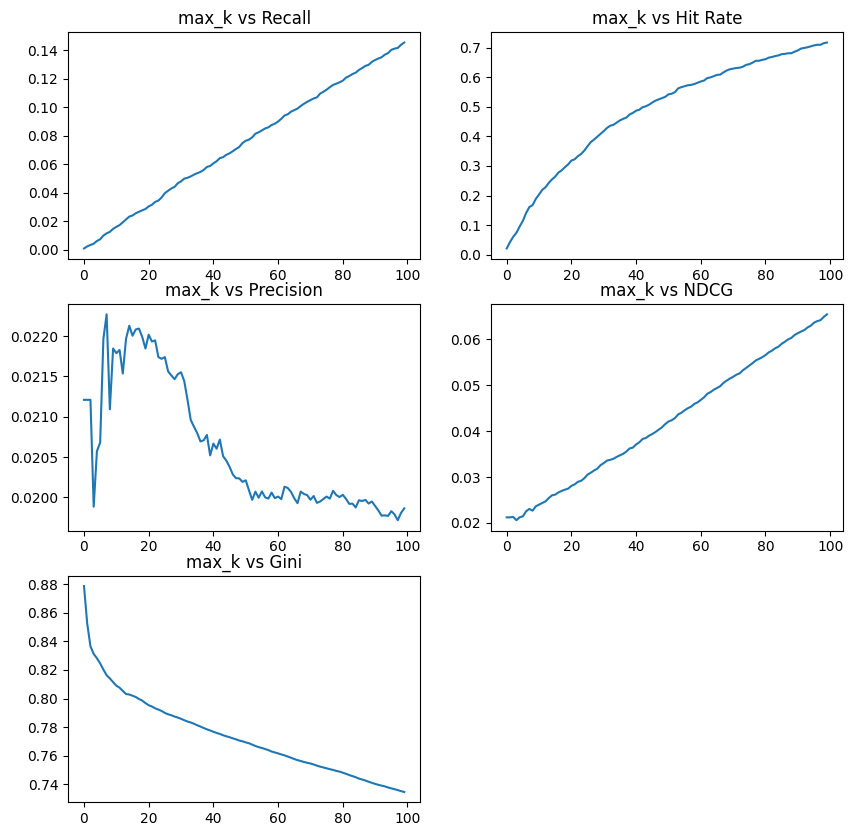

In [44]:
max_k = 100
user_history_length = torch.sum(test_env.current_user_history, 1).detach().cpu().numpy()
test_res_ = torch.stack(test_res).transpose(0,1).detach().cpu().numpy()
report = get_test_results(test_res_, user_history_length, test_gini_coefficient, max_k)

%matplotlib inline
recall = np.mean(report["recall"],0)
hit_rate = np.mean(report["hit_rate"],0)
precision = np.mean(report["precision"],0)
ndcg = np.mean(report["ndcg"],0)
gini_index = report["gini_index"]

plt.figure(figsize = (10,10))
plt.subplot(3,2,1)
plt.plot(np.arange(max_k), recall)
#plt.plot(recall)
plt.title("max_k vs Recall")
plt.subplot(3,2,2)
plt.plot(np.arange(max_k), hit_rate)
plt.title("max_k vs Hit Rate")
plt.subplot(3,2,3)
plt.plot(np.arange(max_k), precision)
plt.title("max_k vs Precision")
plt.subplot(3,2,4)
plt.plot(np.arange(max_k), ndcg)
plt.title("max_k vs NDCG")
plt.subplot(3,2,5)
plt.plot(np.arange(max_k), gini_index)
plt.title("max_k vs Gini")
plt.show()